# Packages and function

In [1]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, constants

# import functions required for processing of FRS data
import frsprocessing as frs
import tdf

%load_ext autoreload
%autoreload 2

# Input/Output

In [2]:
# import and load FRS traces
metafile = pd.read_excel(r"data\ISA1 raw data\FRSMetaInfoSet.xlsx", sheet_name='FRSMetaInfoSet', converters={'sample_name':str}) # read metafile

t_raw = np.load(r'data\ISA1 raw data\t_raw.npy')
td_ref_raw = np.load(r'data\ISA1 raw data\td_ref_raw.npy')
td_sam_raw = np.load(r'data\ISA1 raw data\td_sam_raw.npy')

# Fig 1
## a + b td and noise structure

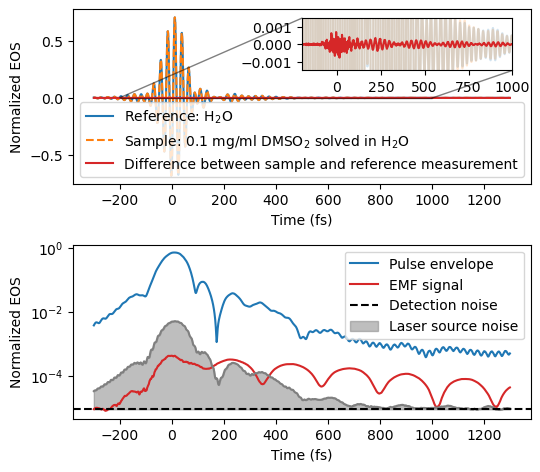

In [4]:
# calculate the referenced sample response hc from the raw td-data
t, td_ref,td_sam, freq, hc = frs.frs_fft(t_raw,td_ref_raw,td_sam_raw)

idx_f1, idx_f2 = (np.abs(freq - 900)).argmin(), (np.abs(freq - 1500)).argmin() # set limits of the filter in wavenumbers
idx_t1, idx_t2 = (np.abs(t - -300)).argmin(), (np.abs(t - 1300)).argmin() # set limits of the filter in wavenumbers

# select all measurements of 100ug/ml concentration at one specific measurement day
index = metafile[(metafile["sequence ID"] == 1667) & (metafile["Conc [ug/ml]"] == 100)].index.to_numpy()

# calc mean and difference traces, td-noise and the pulse envelope
td_ref_mean = np.mean(td_ref[index],axis=0)
td_sam_mean = np.mean(td_sam[index],axis=0)
td_diff_mean = td_ref_mean - td_sam_mean
td_noise = signal.savgol_filter(np.std(td_ref[index],axis=0), 101,2) # relative intensity noise - smoothed for better appearance
td_env = np.abs(signal.hilbert(td_ref_mean)) # pulse envelope
td_env_diff = signal.savgol_filter(np.abs(signal.hilbert(td_diff_mean)), 101,2) # pulse envelope of the molecular signal


### plotting ###

fig, ax = plt.subplots(2,1, figsize= (18/1.2/2.54,2.7*3*2/1.2/2.54)) # paper version

ax[0].plot(t[idx_t1:idx_t2],td_ref_mean[idx_t1:idx_t2], color='tab:blue', label = 'Reference: H$_2$O')
ax[0].plot(t[idx_t1:idx_t2],td_sam_mean[idx_t1:idx_t2], color='tab:orange', ls='--', label = 'Sample: 0.1 mg/ml DMSO$_2$ solved in H$_2$O')
ax[0].plot(t[idx_t1:idx_t2],td_diff_mean[idx_t1:idx_t2], color='tab:red', label = 'Difference between sample and reference measurement')

ax[0].legend(loc=4)

ax[1].semilogy(t[idx_t1:idx_t2], td_env[idx_t1:idx_t2], label='Pulse envelope')
ax[1].plot(t[idx_t1:idx_t2], td_env_diff[idx_t1:idx_t2], color='tab:red', label = 'EMF signal')
ax[1].semilogy(t[idx_t1:idx_t2], td_noise[idx_t1:idx_t2], color='tab:gray')
ax[1].axhline(y=9e-6, color='k', linestyle='--', label='Detection noise')
ax[1].fill_between(t[idx_t1:idx_t2], 9e-6, td_noise[idx_t1:idx_t2], color='tab:gray',alpha=0.5, label='Laser source noise')

ax[1].legend()

axins = ax[0].inset_axes([0.5, 0.65, 0.46, 0.3])
axins.plot(t[idx_t1:idx_t2],td_ref_mean[idx_t1:idx_t2], color='tab:blue', label = 'water reference', alpha=0.2)
axins.plot(t[idx_t1:idx_t2],td_sam_mean[idx_t1:idx_t2], color='tab:orange', label = '1 mg/ml DMSO$_2$ solved in water', alpha=0.2)
axins.plot(t[idx_t1:idx_t2],td_diff_mean[idx_t1:idx_t2], color='tab:red', label = 'difference between sample and reference measurement')

# sub region of the original image
x1, x2, y1, y2 = -200, 1000, -0.0015, 0.0015
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels()
#axins.set_yticklabels([])
plt.subplots_adjust(hspace=0.35)
ax[0].indicate_inset_zoom(axins, edgecolor="black")

for i in range(2):
    ax[i].set_xlabel("Time (fs)"), ax[i].set_ylabel("Normalized EOS")

# Fig 2
## a) Standard approach

array([ 377,  637,  650,  659,  661,  665, 1659, 1660, 1662, 1666, 1667],
      dtype=int64)

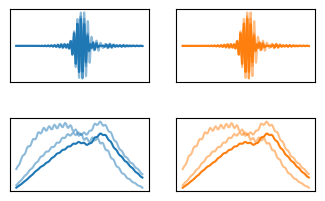

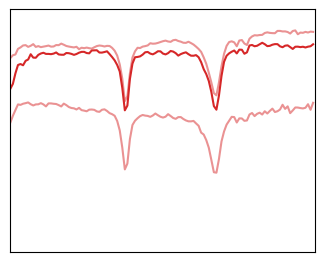

In [5]:
# calculate the referenced sample response from the raw td-data
t, td_ref,td_sam, freq, hc = frs.frs_fft(t_raw,td_ref_raw,td_sam_raw)

f1, f2 = 950, 1450 # limits of the applied Tukey filter in the FD
t1, t2 = 550, 6000 # limits of the applied Tukey filter in the td

# perform time-domain filtering and pathlength-correction - will be used later
w_f = tdf.tukeyF(freq,f1,f2,25) # frequewncy filter to select region of interest
hc_tdf = tdf.tdf(freq,hc,t1,t2,w_f=w_f) # time-domain filtered spectra

# calculate the td-differences 
td_diff, fdc_diff = frs.calc_diff(metafile, td_ref, td_sam, t, t1, t2, 50, corr=np.ones(metafile['sequence ID'].unique().size))

# select plot range
idx_f1, idx_f2 = (np.abs(freq - 950)).argmin(), (np.abs(freq - 1450)).argmin() # set limits of the filter in wavenumbers
idx_t1, idx_t2 = (np.abs(t - -500)).argmin(), (np.abs(t - 500)).argmin() # set limits of the filter in wavenumbers

### plotting the TD traces and the corresponding spectra for several selected 100 ug/ml measurements of DMSO2 ###
conc = 100 # to select which concentration will be evaluated [ug/ml]

fig, ax = plt.subplots(2, 2, figsize= (5*2/2.54,3*2/2.54))
ax=ax.ravel()
for i, seq in enumerate([1667, 1660, 1659]): # loop through a few measurement days and plot the corresponding data
    alpha = 1 if i == 0 else  0.5
    # calculate the mean td traces and spectra of a given measurement day and concentration
    td_ref_mean,td_sam_mean,td_diff_mean,td_hc,td_hc_tdf,fdc_ref,fdc_sam,fdc_diff,fdc_diff_tdf,hc,hc_tdf = frs.meanspectra(metafile, seq, conc, t, freq, td_ref,td_sam)
    ax[0].plot(t[idx_t1:idx_t2],td_ref_mean[idx_t1:idx_t2], color='tab:blue', alpha=alpha) # td-trace reference
    ax[1].plot(t[idx_t1:idx_t2],td_sam_mean[idx_t1:idx_t2], color='tab:orange', alpha=alpha) # td-trace sample
    ax[2].plot(freq[idx_f1:idx_f2],np.abs(fdc_ref)[idx_f1:idx_f2], color='tab:blue', alpha=alpha) # spectrum of the reference pulse
    ax[3].plot(freq[idx_f1:idx_f2],np.abs(fdc_sam)[idx_f1:idx_f2], color='tab:orange', alpha=alpha) # spectrum of the sample pulse

for i in range(4):
    ax[i].set_xticklabels([]), ax[i].set_yticklabels([]), ax[i].set_xticks([]), ax[i].set_yticks([])

plt.subplots_adjust(hspace=0.5)

### plot the corresponding transfer functions using the standard approach ###
fig, ax = plt.subplots(1, figsize= (5*2/2.54,4*2/2.54))
for i, seq in enumerate([1667, 1660, 1659]):
    alpha = 1 if i == 0 else  0.5
    # calculate the mean td traces and spectra of a given measurement day and concentration
    td_ref_mean,td_sam_mean,td_diff_mean,td_hc,td_hc_tdf,fdc_ref,fdc_sam,fdc_diff,fdc_diff_tdf,hc,hc_tdf = frs.meanspectra(metafile, seq, conc, t, freq, td_ref,td_sam)
    ax.plot(freq[idx_f1:idx_f2],np.real(hc)[idx_f1:idx_f2], color='tab:red', label = 'real', alpha=alpha) # real part of the complex sample transfer function

ax.set_xlim([950,1450]), ax.set_ylim([0.993,1.002])
ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_xticks([]), ax.set_yticks([])
metafile["sequence ID"].unique()

## b) Time-domain differences

array([ 377,  637,  650,  659,  661,  665, 1659, 1660, 1662, 1666, 1667],
      dtype=int64)

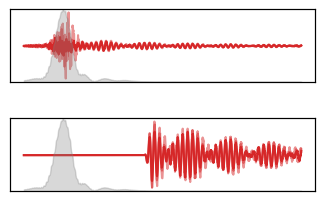

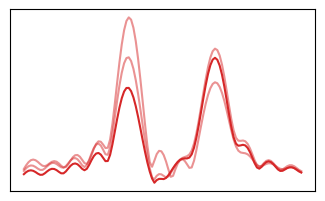

In [6]:
### plotting the TD difference traces and the corresponding spectra for several selected 100 ug/ml measurements of DMSO2 ###
t1, t2 = 500, 1300 # limits of the filter in the time-domain
fig, ax = plt.subplots(2, 1, figsize= (5*2/2.54,3*2/2.54))
ax=ax.ravel()
for i, seq in enumerate([1667, 1660, 1659]):
    alpha = 1 if i == 0 else  0.5
    # calculate the mean td traces and spectra of a given measurement day and concentration
    td_ref_mean,td_sam_mean,td_diff_mean,td_hc,td_hc_tdf,fdc_ref,fdc_sam,fdc_diff,fdc_diff_tdf,hc,hc_tdf = frs.meanspectra(metafile, seq, conc, t, freq, td_ref,td_sam)
    idx_t1, idx_t2 = (np.abs(t - -200)).argmin(), (np.abs(t - 1300)).argmin() # set limits of the filter in wavenumbers
    ax[0].plot(t[idx_t1:idx_t2],td_diff_mean[idx_t1:idx_t2], color='tab:red', alpha=alpha) # td-difference
    ax[1].plot(t[idx_t1:idx_t2],(td_diff_mean*tdf.tukeyF(t,t1,6000,50))[idx_t1:idx_t2], color='tab:red', alpha=alpha) # time-filtered td-difference
for i in range(2):
    ax[i].set_xticklabels([]), ax[i].set_yticklabels([]), ax[i].set_xticks([]), ax[i].set_yticks([])

# also plot the excess noise calculated above #
axyy = ax[1].twinx()
axyy.fill_between(t[idx_t1:idx_t2], 0, td_noise[idx_t1:idx_t2], color='tab:gray', alpha=0.3, label='excess noise')
axyy.set_ylim(0, td_noise.max())
axyy.set_yticklabels([]), axyy.set_yticks([])
axyy = ax[0].twinx()
axyy.fill_between(t[idx_t1:idx_t2], 0, td_noise[idx_t1:idx_t2], color='tab:gray', alpha=0.3, label='excess noise')
axyy.set_ylim(0, td_noise.max())
axyy.set_yticklabels([]), axyy.set_yticks([])
plt.subplots_adjust(hspace=0.5)

### plotting - power spectral density of the filtered td-differnces ###
fig, ax = plt.subplots(1, figsize= (5*2/2.54,3*2/2.54))
for i, seq in enumerate([1667, 1660, 1659]):
    alpha = 1 if i == 0 else  0.5
    # calculate the mean td traces and spectra of a given measurement day and concentration
    td_ref_mean,td_sam_mean,td_diff_mean,td_hc,td_hc_tdf,fdc_ref,fdc_sam,fdc_diff,fdc_diff_tdf,hc,hc_tdf = frs.meanspectra(metafile, seq, conc, t, freq, td_ref,td_sam, t1=t1, t2=t2)
    ax.plot(freq[idx_f1:idx_f2],np.abs(fdc_diff_tdf)[idx_f1:idx_f2], color='tab:red', alpha=alpha) # spectrum of the td-differences

ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_xticks([]), ax.set_yticks([])
    
metafile["sequence ID"].unique()

## c) Time-domain filtering

array([ 377,  637,  650,  659,  661,  665, 1659, 1660, 1662, 1666, 1667],
      dtype=int64)

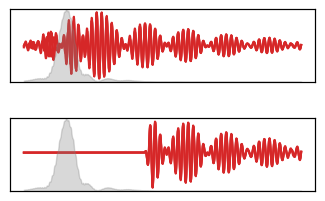

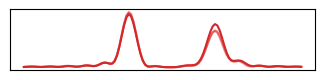

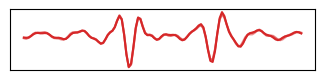

In [7]:
### plotting the different steps of the time-domain filtering approach for several selected 100 ug/ml measurements of DMSO2 ###
t1, t2 = 500, 1500 # limits of the filter in the time-domain

t_tdf = np.fft.fftshift(np.fft.fftfreq(freq.size, d=np.diff(freq*constants.c*100).mean()))*1E15 # time-axis
idx_t1, idx_t2 = (np.abs(t_tdf - -200)).argmin(), (np.abs(t_tdf - 1300)).argmin() # set limits of the filter in wavenumbers

### plotting - time-domain representation of the sample transfer function  ### 
fig, ax = plt.subplots(2, 1, figsize= (5*2/2.54,3*2/2.54))
ax=ax.ravel()
for i, seq in enumerate([1667, 1660, 1659]):
    alpha = 1 if i == 0 else  0.5
    # calculate the mean td traces and spectra of a given measurement day and concentration
    td_ref_mean,td_sam_mean,td_diff_mean,td_hc,td_hc_tdf,fdc_ref,fdc_sam,fdc_diff,fdc_diff_tdf,hc,hc_tdf = (frs.meanspectra(metafile, seq, conc, t, freq, td_ref,td_sam, t1=t1, t2=t2))
    ax[0].plot(t_tdf[idx_t1:idx_t2],td_hc.real[idx_t1:idx_t2]*1e5, color='tab:red', label = 'water reference')
    ax[1].plot(t_tdf[idx_t1:idx_t2],td_hc_tdf.real[idx_t1:idx_t2]*1e5, color='tab:red', label = 'water reference')
for i in range(2):
    ax[i].set_xticklabels([]), ax[i].set_yticklabels([]), ax[i].set_xticks([]), ax[i].set_yticks([])

# also plot the excess noise #    
axyy = ax[1].twinx()
t_tdf = t-t[t.size//2]
idx_t1, idx_t2 = (np.abs(t_tdf - -200)).argmin(), (np.abs(t_tdf - 1300)).argmin() # set limits of the filter in wavenumbers
axyy.fill_between((t-t[t.size//2])[idx_t1:idx_t2], 0, np.roll(td_noise, np.abs(t).argmin())[idx_t1:idx_t2],
                   color='tab:gray', alpha=0.3, label='excess noise')
axyy.set_ylim(0, td_noise.max())
axyy.set_yticklabels([]), axyy.set_yticks([])
axyy = ax[0].twinx()
axyy.fill_between((t-t[t.size//2])[idx_t1:idx_t2], 0, np.roll(td_noise, np.abs(t).argmin())[idx_t1:idx_t2],
                   color='tab:gray', alpha=0.3, label='excess noise')
axyy.set_ylim(0, td_noise.max())
axyy.set_yticklabels([]), axyy.set_yticks([])
plt.subplots_adjust(hspace=0.5)

### plotting - power spectrum of the time-domain filtered spectrum  ### 
fig, ax = plt.subplots(1, figsize= (5*2/2.54,1*2/2.54))
for i, seq in enumerate([1667, 1660, 1659]):
    alpha = 1 if i == 0 else  0.5
    td_ref_mean,td_sam_mean,td_diff_mean,td_hc,td_hc_tdf,fdc_ref,fdc_sam,fdc_diff,fdc_diff_tdf,hc,hc_tdf = (
        frs.meanspectra(metafile, seq, conc, t, freq, td_ref,td_sam, t1=t1, t2=t2))
    ax.plot(freq[idx_f1:idx_f2],(np.abs(hc_tdf)**2)[idx_f1:idx_f2], color='tab:red', alpha=alpha)

ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_xticks([]), ax.set_yticks([])

### plotting - time-domain filtered sample transfer function ### 
fig, ax = plt.subplots(1, figsize= (5*2/2.54,1*2/2.54))
for i, seq in enumerate([1667, 1660, 1659]):
    alpha = 1 if i == 0 else  0.5
    # calculate the mean td traces and spectra of a given measurement day and concentration
    td_ref_mean,td_sam_mean,td_diff_mean,td_hc,td_hc_tdf,fdc_ref,fdc_sam,fdc_diff,fdc_diff_tdf,hc,hc_tdf = frs.meanspectra(metafile, seq, conc, t, freq, td_ref,td_sam, t1=t1, t2=t2)
    ax.plot(freq[idx_f1:idx_f2],np.real(hc_tdf)[idx_f1:idx_f2]-1, color='tab:red', alpha=alpha)

ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_xticks([]), ax.set_yticks([])

metafile["sequence ID"].unique()